In [1]:
import numpy as np 
import time 
import matplotlib.pyplot as plt
from generators.weibull_gen import Weibull_gen
from hypothesis import param
from hypothesis import noparam

%load_ext autoreload
%autoreload 2

---
# <center>PLAYGROUND

---

## <center> Weibull generator

### Define dict of experiments

Key is name of experiment, and values is parameters of experiment

In [2]:
weibull_experiments = {
    'm3.5_v6' : {'m' : 3.5, 'v' : 6},
    'm2.5_v1.2' : {'m' : 2.5, 'v' : 1.2},
    'm1.1_v4.5' : {'m' : 1.1, 'v' : 4.5}
}


desirable_sizes = [50, 200, 1000]

### Plot the probability density function

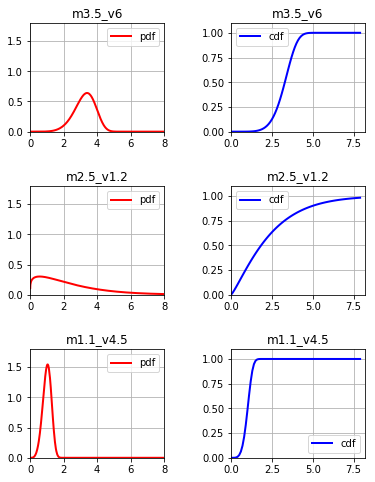

In [3]:
# build a graph of theory probability distribution function 
num_of_points = 1000
fig, axes = plt.subplots(len(weibull_experiments), 2, figsize=(6, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
i = 0
for name, params in weibull_experiments.items():
    m, v = params['m'], params['v']
    w = Weibull_gen(m, v) 
    x = np.random.uniform(size=num_of_points) * 8 
    y = w._pdf(x)
    y = y[x.argsort()]
    x = np.sort(x)  
    
    ax = axes[i, 0]
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 1.8)
    ax.plot(x, y, color='red', label='pdf', linewidth=2)
    ax.set_title(name)
    ax.legend()
    ax.grid() 
    
    
    ax = axes[i, 1]
    theory_line_X_values = np.arange(start=0, stop=8, step=0.1)
    theory_line_Y_values = np.apply_along_axis(w._cdf, 0, theory_line_X_values)
    ax.set_xlim(0, 8.2)
    ax.set_ylim(0, 1.1)
    ax.plot(theory_line_X_values, theory_line_Y_values, color='blue', label='cdf', linewidth=2)
    ax.set_title(name)
    ax.legend()
    ax.grid() 
    
    i+=1

plt.show()

### Perform experiments with weibull distribution

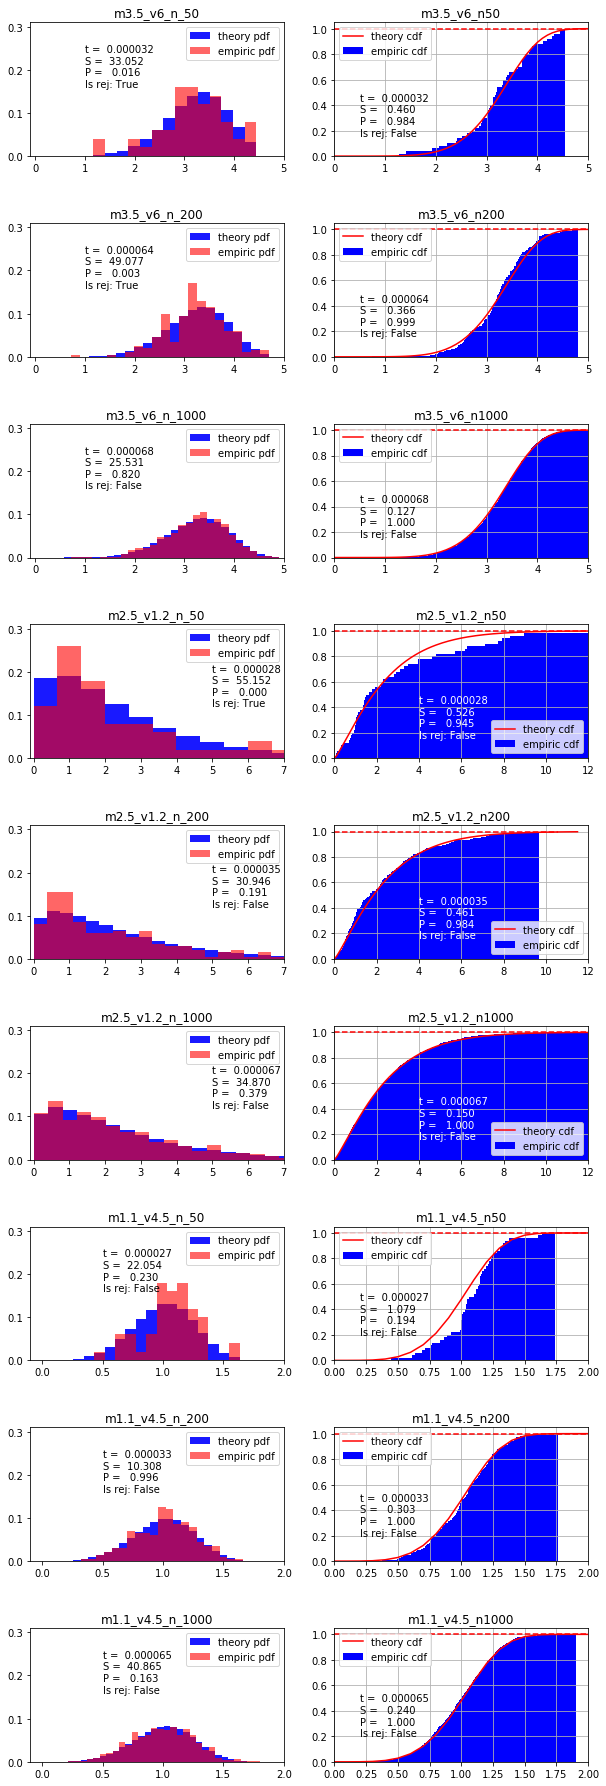

In [69]:
fig, axes = plt.subplots(len(weibull_experiments) * len(desirable_sizes), 2, figsize=(10, 32))
plotted_row = 0
plt.subplots_adjust(hspace=0.5, wspace=0.2)
x_pdf_limits_hardcode = [5, 7, 2]
x_cdf_limits_hardcode = [5, 12, 2]
sequence_with_50_elements = []

text_coords = np.array([
    [[1, 0.16], [0.5, 0.16]],
    [[5, 0.12], [4, 0.16]],
    [[0.5, 0.16], [0.2, 0.2]]
    ])

for name, params in weibull_experiments.items():
    for idx, size in enumerate(desirable_sizes):
        weib = Weibull_gen(v=params['v'], m=params['m'])
        start = time.time()
        seq = weib.generate(size)
        end = time.time() 
        
        taken_time = end - start
        
        # calculate empirical probability row
        k = int(5 * np.log(size))
        upper_bound = max(seq)
        interval_width = upper_bound / k
        empiric_freq, _ = param._freqs(seq, 0, upper_bound, k, normalized=True)
        if size == 50:
            sequence_with_50_elements.append(seq)
        
        # calculate theory probability row
        theory_prob_row = []
        for i in range(k):
            F_x2 = weib._cdf((i + 1) * interval_width)
            F_x1 = weib._cdf(i * interval_width)
            theory_prob_row.append(F_x2 - F_x1)
        theory_prob_row = np.array(theory_prob_row)
        
        # build array of left bounds of intervals
        left_bounds = np.arange(k) * interval_width
        
        # perform test
        chi_is_rej, chi_s, chi_p = param.chisquare(empiric_freq, theory_prob_row, size, 0.05)
        kol_is_rej, kol_s, kol_p = noparam.kolmogorov(seq, weib._cdf, verbose=False)
        
        ax = axes[plotted_row]
        text_x = 1 
        # 1) shisquare plots
        ax[0].set_ylim(-0.0, 0.31)
        ax[0].set_xlim(-.1, x_pdf_limits_hardcode[plotted_row // 3])
        ax[0].bar(left_bounds, 
                theory_prob_row, 
                label='theory pdf', 
                width=interval_width, 
                color='blue', 
                alpha=0.9, 
                align='edge')
        ax[0].bar(left_bounds, 
                empiric_freq, 
                label='empiric pdf', 
                width=interval_width,
                color='red', 
                alpha=0.6,
                align='edge')
        ax[0].set_title(name + '_n_' + str(size))
        ax[0].legend() 
        text_info = ('t = % 7.6f\nS = % 7.3f\nP = % 7.3f\nIs rej: %r' % (taken_time, chi_s, chi_p, chi_is_rej))
        ax[0].text(text_coords[plotted_row//3, 0, 0], 
                   text_coords[plotted_row//3, 0, 1], 
                   text_info, fontdict={'size': 10})
        
        
        # 2) kolmogorov plots
        # 2.0) calculate probability row
        lower_bound = 0
        upper_bound = max(seq)
        ax[1].set_xlim(0, x_cdf_limits_hardcode[plotted_row // 3])
        
        # 2.1) plot bar of empirical probability row
        empiric_line_X_values = sorted(seq.copy())
        empiric_line_Y_values = np.arange(1, len(seq) + 1) / len(seq)
        widths = np.ediff1d(empiric_line_X_values)
        widths = np.append(widths, 0.1)
        ax[1].bar(empiric_line_X_values, 
                  empiric_line_Y_values, 
                  widths, 
                  color='blue', 
                  label='empiric cdf', 
                  linewidth=2, 
                  align='edge')

        # 2.2) build a graph of theory cumulative distribution function 
        theory_line_X_values = np.arange(start=0, stop=upper_bound + 2, step=0.1)
        theory_line_Y_values = np.apply_along_axis(weib._cdf, 0, theory_line_X_values)
        ax[1].plot(theory_line_X_values, theory_line_Y_values, color='red', label='theory cdf', linewidth=1.5)

        # 2.3) y = 1 border
        ax[1].hlines(1, 0, upper_bound + 1, colors='red', linestyles='dashed')

        # show plots/graphs
        text_color = 'white' if plotted_row//3 == 1 else 'black'
        ax[1].grid()
        ax[1].legend() 
        ax[1].set_title(name + '_n' + str(size))
        text_info = ('t = % 7.6f\nS = % 7.3f\nP = % 7.3f\nIs rej: %r' % (taken_time, kol_s, kol_p, kol_is_rej))
        ax[1].text(text_coords[plotted_row//3, 1, 0], 
                   text_coords[plotted_row//3, 1, 1], 
                   text_info, 
                   fontdict={
                       'size': 10,
                       'color' : text_color})
        
        plotted_row += 1
        
#         print(s, p)


#         ax = axes[plotted_row, idx]
#         ax.set_ylim((0, 0.7))
#         ax.set_xlim((-0.9, 5))
#         ax.bar(uniq, empiric_freq, color='blue', label='emirical')
#         ax.bar(uniq, bnm._prob_row, alpha=0.45, color='red', edgecolor='red', linewidth=3, linestyle='--', label='theory')

#         ax.set_title('n' + str(size) + '_' + name)
#         ax.legend() 
        
        
plt.show() 

#### Print sequences with 50 elements

In [70]:
for i in sequence_with_50_elements:
    for j in range(len(i)):
        print('% 3.2f' % i[j], end =" ")
    print() 
    print() 

 1.92  3.02  3.69  3.13  3.94  2.51  1.40  3.33  3.75  3.74  1.28  4.18  3.57  3.13  2.39  2.89  2.41  3.12  2.93  4.44  3.90  3.01  2.90  3.20  3.06  3.20  2.07  3.37  4.32  2.71  4.11  3.33  3.18  3.83  4.29  3.71  3.61  2.61  3.44  3.16  3.85  2.22  3.39  4.45  3.70  2.86  3.02  3.30  2.77  3.04 

 2.22  0.92  0.79  4.81  6.29  1.38  0.09  0.28  3.10  1.01  0.38  1.13  8.30  0.97  1.52  0.81  0.02  1.37  1.63  0.12  5.70  2.47  7.73  3.97  1.39  1.45  2.92  1.93  1.03  0.68  1.05  1.01  2.27  12.65  7.13  1.20  2.31  0.98  4.59  1.36  8.95  3.27  6.16  3.50  2.80  3.94  0.32  0.73  7.92  1.77 

 1.12  1.04  1.31  0.77  0.69  1.01  1.15  0.44  1.14  1.14  1.22  1.34  0.99  1.15  1.20  1.00  1.13  1.10  0.76  0.88  1.16  1.33  0.61  1.64  1.04  1.61  1.00  1.23  1.00  1.00  1.04  1.02  1.18  1.15  1.25  1.00  0.83  0.63  1.04  1.03  1.31  0.92  0.72  1.06  1.21  1.37  1.12  1.24  1.28  0.86 

